In [6]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.impute import SimpleImputer



reading csv dataset


In [11]:
df = pd.read_csv('Survival_dataset.csv')
y = df['In-hospital_death']

In [12]:
df = df.drop([
            'Length_of_stay',
            'Survival',
            'SAPS-I',
            'SOFA',
            'In-hospital_death'
        ], axis=1)

In [13]:
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(
            imputer.fit_transform(df),
            columns=df.columns
        )


In [10]:
df_imputed

,recordid,Age,Gender,Height,Weight,CCU,CSRU,SICU,DiasABP_first,GCS_first,...,SysABP_last,TroponinI_last,TroponinT_last,WBC_last,Weight_last,pH_last,MechVentStartTime,MechVentDuration,MechVentLast8Hour,UrineOutputSum
0,132539.0,54.0,0.0,171.985856,81.474832,0.0,0.0,1.0,62.370637,15.0,...,122.461871,6.466341,1.002283,9.4,85.037344,7.398693,285.17675,1912.00514,0.620799,12.314749
1,132540.0,76.0,1.0,175.300000,76.000000,0.0,1.0,0.0,67.000000,3.0,...,103.000000,6.466341,1.002283,13.3,81.600000,7.370000,71.00000,360.00000,0.000000,5.000000
2,132541.0,44.0,0.0,171.985856,56.700000,0.0,0.0,0.0,81.000000,7.0,...,126.000000,6.466341,1.002283,6.2,56.700000,7.470000,617.00000,2160.00000,1.000000,14.000000
3,132543.0,68.0,1.0,180.300000,84.600000,0.0,0.0,0.0,62.370637,15.0,...,122.461871,6.466341,1.002283,7.9,84.600000,7.398693,285.17675,1912.00514,0.620799,12.314749
4,132545.0,88.0,0.0,171.985856,81.474832,0.0,0.0,0.0,62.370637,15.0,...,122.461871,6.466341,1.002283,4.8,85.037344,7.398693,285.17675,1912.00514,0.620799,12.314749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,142665.0,70.0,0.0,171.985856,87.000000,0.0,0.0,1.0,50.000000,3.0,...,152.000000,6.466341,1.002283,17.5,85.037344,7.390000,23.00000,1200.00000,0.000000,6.000000
3996,142667.0,25.0,1.0,171.985856,166.400000,0.0,0.0,0.0,62.370637,15.0,...,122.461871,6.466341,1.002283,3.0,166.400000,7.398693,285.17675,1912.00514,0.620799,12.314749
3997,142670.0,44.0,1.0,171.985856,109.000000,0.0,0.0,0.0,67.000000,8.0,...,113.000000,6.466341,1.002283,10.6,109.000000,7.410000,80.00000,2580.00000,1.000000,15.000000
3998,142671.0,37.0,1.0,171.985856,87.400000,0.0,0.0,0.0,88.000000,6.0,...,145.000000,6.466341,1.002283,11.5,87.400000,7.340000,82.00000,2585.00000,1.000000,15.000000


## In-hospital mortality prediction (weighted recall/precision)

This section is a clean, portfolio-ready workflow:
- prepare data
- split into train/validation/test
- train Logistic Regression, Random Forest, and Boosting
- tune decision thresholds
- compare final test performance with weighted objective (80% recall, 20% precision)

In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_sample_weight

### 1) Load dataset and define features/target

We keep the same target (`In-hospital_death`) and drop columns that should not be used as predictors.

In [2]:
TARGET_COLUMN = 'In-hospital_death'
DROP_COLUMNS = [
    'Length_of_stay',
    'Survival',
    'SAPS-I',
    'SOFA',
    TARGET_COLUMN,
]

df = pd.read_csv('Survival_dataset.csv')
y = df[TARGET_COLUMN].astype(int)
X = df.drop(DROP_COLUMNS, axis=1)

print('Dataset shape:', df.shape)
print('Feature matrix shape:', X.shape)
print('Positive class rate:', round(y.mean(), 4))

Dataset shape: (4000, 120)
Feature matrix shape: (4000, 115)
Positive class rate: 0.1385


### 2) Split into train/validation/test

We use stratified splits to preserve class imbalance in all subsets:
- 60% train
- 20% validation
- 20% test

In [3]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y,
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    random_state=42,
    stratify=y_temp,
)

print('Train size:', len(X_train))
print('Validation size:', len(X_val))
print('Test size:', len(X_test))

Train size: 2800
Validation size: 900
Test size: 300


### 3) Define weighted recall/precision evaluation

We tune thresholds with a weighted objective:
- 80% importance: recall
- 20% importance: precision

Score used for selection: `0.8 * recall + 0.2 * precision`.
Tie-breakers: recall, F1, then lower threshold.

In [32]:
def compute_metrics(y_true, y_pred):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true,
        y_pred,
        average='binary',
        zero_division=0,
    )
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }


def evaluate_thresholds(
    model,
    X_val,
    y_val,
    thresholds,
    recall_weight=0.8,
    precision_weight=0.2,
):
    val_proba = model.predict_proba(X_val)[:, 1]
    rows = []

    for thr in thresholds:
        y_pred = (val_proba >= thr).astype(int)
        metrics = compute_metrics(y_val, y_pred)
        weighted_score = (
            recall_weight * metrics['recall']
            + precision_weight * metrics['precision']
        )
        rows.append(
            {
                'threshold': float(thr),
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'f1': metrics['f1'],
                'weighted_score': weighted_score,
            }
        )

    threshold_df = pd.DataFrame(rows).sort_values(
        by=['weighted_score', 'recall', 'f1', 'threshold'],
        ascending=[False, False, False, True],
    )
    best = threshold_df.iloc[0].to_dict()
    return threshold_df, best

### 4) Train models, tune parameters, and compare on test

- Logistic Regression: fit once, then tune threshold with weighted score.
- Random Forest: test multiple hyperparameter sets, tune threshold for each.
- Boosting: test multiple hyperparameter sets, tune threshold for each.
- Selection objective: `0.8 * recall + 0.2 * precision` (validation).
- Final table is ranked by weighted test score, then recall.

In [33]:
RECALL_WEIGHT = 0.8
PRECISION_WEIGHT = 0.2

logistic_model = Pipeline(
    [
        ('imputer', SimpleImputer(strategy='mean')),
        (
            'model',
            LogisticRegression(
                class_weight='balanced',
                solver='liblinear',
                max_iter=5000,
                random_state=42,
            ),
        ),
    ]
)

rf_param_grid = [
    {'n_estimators': 200, 'max_depth': None, 'min_samples_leaf': 1},
    {'n_estimators': 400, 'max_depth': None, 'min_samples_leaf': 1},
    {'n_estimators': 400, 'max_depth': 12, 'min_samples_leaf': 1},
    {'n_estimators': 400, 'max_depth': 10, 'min_samples_leaf': 3},
    {'n_estimators': 600, 'max_depth': 8, 'min_samples_leaf': 5},
]

gb_param_grid = [
    {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1},
    {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 2},
    {'n_estimators': 300, 'learning_rate': 0.03, 'max_depth': 2, 'min_samples_leaf': 3},
    {'n_estimators': 150, 'learning_rate': 0.08, 'max_depth': 2, 'min_samples_leaf': 5},
]

thresholds = np.arange(0.10, 0.95, 0.05)
summary_rows = []

# 1) Logistic Regression
logistic_model.fit(X_train, y_train)
log_val_table, log_best = evaluate_thresholds(
    logistic_model,
    X_val,
    y_val,
    thresholds,
    recall_weight=RECALL_WEIGHT,
    precision_weight=PRECISION_WEIGHT,
)
log_best_threshold = log_best['threshold']

log_test_proba = logistic_model.predict_proba(X_test)[:, 1]
log_y_test_pred = (log_test_proba >= log_best_threshold).astype(int)
log_test_metrics = compute_metrics(y_test, log_y_test_pred)
log_test_weighted_score = (
    RECALL_WEIGHT * log_test_metrics['recall']
    + PRECISION_WEIGHT * log_test_metrics['precision']
)

print('\n' + '=' * 70)
print('LogisticRegression - validation metrics by threshold')
print('=' * 70)
print(log_val_table.to_string(index=False))

summary_rows.append(
    {
        'model': 'LogisticRegression',
        'params': 'default_balanced_liblinear',
        'selected_threshold': log_best_threshold,
        'val_weighted_score': log_best['weighted_score'],
        'val_recall': log_best['recall'],
        'val_precision': log_best['precision'],
        'val_f1': log_best['f1'],
        'test_weighted_score': log_test_weighted_score,
        'test_recall': log_test_metrics['recall'],
        'test_precision': log_test_metrics['precision'],
        'test_f1': log_test_metrics['f1'],
    }
)

# 2) Random Forest parameter search + threshold tuning
rf_runs = []
for rf_params in rf_param_grid:
    rf_model = Pipeline(
        [
            ('imputer', SimpleImputer(strategy='mean')),
            (
                'model',
                RandomForestClassifier(
                    n_estimators=rf_params['n_estimators'],
                    max_depth=rf_params['max_depth'],
                    min_samples_leaf=rf_params['min_samples_leaf'],
                    class_weight='balanced',
                    random_state=42,
                    n_jobs=-1,
                ),
            ),
        ]
    )

    rf_model.fit(X_train, y_train)
    rf_val_table, rf_best = evaluate_thresholds(
        rf_model,
        X_val,
        y_val,
        thresholds,
        recall_weight=RECALL_WEIGHT,
        precision_weight=PRECISION_WEIGHT,
    )

    rf_best_threshold = rf_best['threshold']
    rf_test_proba = rf_model.predict_proba(X_test)[:, 1]
    rf_y_test_pred = (rf_test_proba >= rf_best_threshold).astype(int)
    rf_test_metrics = compute_metrics(y_test, rf_y_test_pred)
    rf_test_weighted_score = (
        RECALL_WEIGHT * rf_test_metrics['recall']
        + PRECISION_WEIGHT * rf_test_metrics['precision']
    )

    params_label = (
        f"n_estimators={rf_params['n_estimators']}, "
        f"max_depth={rf_params['max_depth']}, "
        f"min_samples_leaf={rf_params['min_samples_leaf']}"
    )

    rf_runs.append(
        {
            'model': 'RandomForest',
            'params': params_label,
            'selected_threshold': rf_best_threshold,
            'val_weighted_score': rf_best['weighted_score'],
            'val_recall': rf_best['recall'],
            'val_precision': rf_best['precision'],
            'val_f1': rf_best['f1'],
            'test_weighted_score': rf_test_weighted_score,
            'test_recall': rf_test_metrics['recall'],
            'test_precision': rf_test_metrics['precision'],
            'test_f1': rf_test_metrics['f1'],
            'val_table': rf_val_table,
        }
    )

rf_results_df = pd.DataFrame(rf_runs).sort_values(
    by=['val_weighted_score', 'val_recall', 'val_precision', 'val_f1'],
    ascending=False,
)

best_rf = rf_runs[rf_results_df.index[0]]

print('\n' + '=' * 70)
print('RandomForest - parameter search summary (sorted by weighted validation score)')
print('=' * 70)
print(
    rf_results_df[
        [
            'params',
            'selected_threshold',
            'val_weighted_score',
            'val_recall',
            'val_precision',
            'val_f1',
            'test_weighted_score',
            'test_recall',
            'test_precision',
            'test_f1',
        ]
    ].to_string(index=False)
)

print('\n' + '-' * 70)
print('Best RandomForest threshold table:')
print(best_rf['params'])
print(best_rf['val_table'].to_string(index=False))

summary_rows.append(
    {
        'model': best_rf['model'],
        'params': best_rf['params'],
        'selected_threshold': best_rf['selected_threshold'],
        'val_weighted_score': best_rf['val_weighted_score'],
        'val_recall': best_rf['val_recall'],
        'val_precision': best_rf['val_precision'],
        'val_f1': best_rf['val_f1'],
        'test_weighted_score': best_rf['test_weighted_score'],
        'test_recall': best_rf['test_recall'],
        'test_precision': best_rf['test_precision'],
        'test_f1': best_rf['test_f1'],
    }
)

# 3) Gradient Boosting parameter search + threshold tuning
gb_runs = []
train_sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)

for gb_params in gb_param_grid:
    gb_model = Pipeline(
        [
            ('imputer', SimpleImputer(strategy='mean')),
            (
                'model',
                GradientBoostingClassifier(
                    n_estimators=gb_params['n_estimators'],
                    learning_rate=gb_params['learning_rate'],
                    max_depth=gb_params['max_depth'],
                    min_samples_leaf=gb_params['min_samples_leaf'],
                    random_state=42,
                ),
            ),
        ]
    )

    gb_model.fit(X_train, y_train, model__sample_weight=train_sample_weight)
    gb_val_table, gb_best = evaluate_thresholds(
        gb_model,
        X_val,
        y_val,
        thresholds,
        recall_weight=RECALL_WEIGHT,
        precision_weight=PRECISION_WEIGHT,
    )

    gb_best_threshold = gb_best['threshold']
    gb_test_proba = gb_model.predict_proba(X_test)[:, 1]
    gb_y_test_pred = (gb_test_proba >= gb_best_threshold).astype(int)
    gb_test_metrics = compute_metrics(y_test, gb_y_test_pred)
    gb_test_weighted_score = (
        RECALL_WEIGHT * gb_test_metrics['recall']
        + PRECISION_WEIGHT * gb_test_metrics['precision']
    )

    params_label = (
        f"n_estimators={gb_params['n_estimators']}, "
        f"learning_rate={gb_params['learning_rate']}, "
        f"max_depth={gb_params['max_depth']}, "
        f"min_samples_leaf={gb_params['min_samples_leaf']}"
    )

    gb_runs.append(
        {
            'model': 'GradientBoosting',
            'params': params_label,
            'selected_threshold': gb_best_threshold,
            'val_weighted_score': gb_best['weighted_score'],
            'val_recall': gb_best['recall'],
            'val_precision': gb_best['precision'],
            'val_f1': gb_best['f1'],
            'test_weighted_score': gb_test_weighted_score,
            'test_recall': gb_test_metrics['recall'],
            'test_precision': gb_test_metrics['precision'],
            'test_f1': gb_test_metrics['f1'],
            'val_table': gb_val_table,
        }
    )

gb_results_df = pd.DataFrame(gb_runs).sort_values(
    by=['val_weighted_score', 'val_recall', 'val_precision', 'val_f1'],
    ascending=False,
)

best_gb = gb_runs[gb_results_df.index[0]]

print('\n' + '=' * 70)
print('GradientBoosting - parameter search summary (sorted by weighted validation score)')
print('=' * 70)
print(
    gb_results_df[
        [
            'params',
            'selected_threshold',
            'val_weighted_score',
            'val_recall',
            'val_precision',
            'val_f1',
            'test_weighted_score',
            'test_recall',
            'test_precision',
            'test_f1',
        ]
    ].to_string(index=False)
)

print('\n' + '-' * 70)
print('Best GradientBoosting threshold table:')
print(best_gb['params'])
print(best_gb['val_table'].to_string(index=False))

summary_rows.append(
    {
        'model': best_gb['model'],
        'params': best_gb['params'],
        'selected_threshold': best_gb['selected_threshold'],
        'val_weighted_score': best_gb['val_weighted_score'],
        'val_recall': best_gb['val_recall'],
        'val_precision': best_gb['val_precision'],
        'val_f1': best_gb['val_f1'],
        'test_weighted_score': best_gb['test_weighted_score'],
        'test_recall': best_gb['test_recall'],
        'test_precision': best_gb['test_precision'],
        'test_f1': best_gb['test_f1'],
    }
)

summary_df = pd.DataFrame(summary_rows).sort_values(
    by=['test_weighted_score', 'test_recall', 'test_precision'],
    ascending=False,
)

print('\n' + '#' * 70)
print('FINAL COMPARISON (Logistic vs RandomForest vs Boosting)')
print('#' * 70)
summary_df


LogisticRegression - validation metrics by threshold
 threshold  precision  recall       f1  weighted_score
      0.10   0.195759   0.960 0.325203        0.807152
      0.15   0.214022   0.928 0.347826        0.785204
      0.20   0.236287   0.896 0.373957        0.764057
      0.25   0.250000   0.880 0.389381        0.754000
      0.30   0.259901   0.840 0.396975        0.723980
      0.35   0.282192   0.824 0.420408        0.715638
      0.40   0.280967   0.744 0.407895        0.651393
      0.45   0.296667   0.712 0.418824        0.628933
      0.50   0.319703   0.688 0.436548        0.614341
      0.55   0.346154   0.648 0.451253        0.587631
      0.60   0.367150   0.608 0.457831        0.559830
      0.65   0.387978   0.568 0.461039        0.531996
      0.70   0.412500   0.528 0.463158        0.504900
      0.75   0.411348   0.464 0.436090        0.453470
      0.80   0.438017   0.424 0.430894        0.426803
      0.85   0.441558   0.272 0.336634        0.305912
      0.90 

,model,params,selected_threshold,val_weighted_score,val_recall,val_precision,val_f1,test_weighted_score,test_recall,test_precision,test_f1
2,GradientBoosting,"n_estimators=100, learning_rate=0.1, max_depth...",0.1,0.825638,0.984,0.192188,0.321569,0.837443,1.00000,0.187215,0.315385
1,RandomForest,"n_estimators=600, max_depth=8, min_samples_leaf=5",0.1,0.832680,1.000,0.163399,0.280899,0.832157,1.00000,0.160784,0.277027
0,LogisticRegression,default_balanced_liblinear,0.1,0.807152,0.960,0.195759,0.325203,0.816687,0.97561,0.180995,0.305344


### 5) Practical precision boost: choose threshold with a minimum precision

If precision around 20% is too low, force a minimum precision on validation (for example 30%).
Then pick the threshold with the best weighted score among those valid thresholds.

This usually increases precision and decreases recall slightly.

In [28]:
MIN_VALIDATION_PRECISION = 0.30

def choose_threshold_with_min_precision(val_table, min_precision=0.30):
    filtered = val_table[val_table['precision'] >= min_precision].copy()

    if filtered.empty:
        return None, filtered

    filtered = filtered.sort_values(
        by=['weighted_score', 'recall', 'f1', 'threshold'],
        ascending=[False, False, False, True],
    )
    return filtered.iloc[0].to_dict(), filtered

log_constrained_best, log_valid_thresholds = choose_threshold_with_min_precision(
    log_val_table,
    min_precision=MIN_VALIDATION_PRECISION,
)

if log_constrained_best is None:
    print('No LogisticRegression threshold satisfies the minimum precision.')
else:
    log_thr = log_constrained_best['threshold']
    log_pred = (log_test_proba >= log_thr).astype(int)
    log_m = compute_metrics(y_test, log_pred)
    log_ws = RECALL_WEIGHT * log_m['recall'] + PRECISION_WEIGHT * log_m['precision']

    print('LogisticRegression constrained choice')
    print('Threshold:', round(log_thr, 2))
    print('Validation precision/recall:', round(log_constrained_best['precision'], 4), round(log_constrained_best['recall'], 4))
    print('Test precision/recall:', round(log_m['precision'], 4), round(log_m['recall'], 4))
    print('Test weighted score:', round(log_ws, 4))

rf_best_table = best_rf['val_table']
rf_constrained_best, rf_valid_thresholds = choose_threshold_with_min_precision(
    rf_best_table,
    min_precision=MIN_VALIDATION_PRECISION,
)

if rf_constrained_best is None:
    print('\nNo RandomForest threshold satisfies the minimum precision.')
else:
    rf_thr = rf_constrained_best['threshold']
    rf_pred = (rf_test_proba >= rf_thr).astype(int)
    rf_m = compute_metrics(y_test, rf_pred)
    rf_ws = RECALL_WEIGHT * rf_m['recall'] + PRECISION_WEIGHT * rf_m['precision']

    print('\nRandomForest constrained choice')
    print('Threshold:', round(rf_thr, 2))
    print('Validation precision/recall:', round(rf_constrained_best['precision'], 4), round(rf_constrained_best['recall'], 4))
    print('Test precision/recall:', round(rf_m['precision'], 4), round(rf_m['recall'], 4))
    print('Test weighted score:', round(rf_ws, 4))

print('\nTip: increase MIN_VALIDATION_PRECISION to push precision higher.')

LogisticRegression constrained choice
Threshold: 0.5
Validation precision/recall: 0.3197 0.688
Test precision/recall: 0.303 0.7317
Test weighted score: 0.646

RandomForest constrained choice
Threshold: 0.3
Validation precision/recall: 0.3 0.864
Test precision/recall: 0.296 0.9024
Test weighted score: 0.7812

Tip: increase MIN_VALIDATION_PRECISION to push precision higher.


### 6) Feasibility check for a strict operating point (Precision ≥ 0.80, Recall ≥ 0.90)

This cell tests several strong model candidates and searches thresholds.
Now includes:
- Logistic Regression
- Random Forest / Extra Trees / Gradient Boosting variants
- XGBoost (if installed)
- LightGBM (if installed)

It reports:
- whether **both** targets can be reached together,
- best precision achievable while keeping recall ≥ 0.90,
- best recall achievable while keeping precision ≥ 0.80.

If no model meets both, we likely need better features, more data, or a different problem framing.

In [4]:
from sklearn.ensemble import ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.metrics import precision_recall_curve

TARGET_PRECISION = 0.80
TARGET_RECALL = 0.90

# Optional boosting libraries
xgb_available = True
lgbm_available = True

try:
    from xgboost import XGBClassifier
except ImportError:
    xgb_available = False

try:
    from lightgbm import LGBMClassifier
except ImportError:
    lgbm_available = False

# Class imbalance ratio for external boosting libraries
neg_count = int((y_train == 0).sum())
pos_count = int((y_train == 1).sum())
scale_pos_weight = neg_count / max(pos_count, 1)

candidate_models = {
    'LogisticRegression': Pipeline(
        [
            ('imputer', SimpleImputer(strategy='mean')),
            ('model', LogisticRegression(class_weight='balanced', solver='liblinear', max_iter=5000, random_state=42)),
        ]
    ),
    'RandomForest_stronger': Pipeline(
        [
            ('imputer', SimpleImputer(strategy='mean')),
            ('model', RandomForestClassifier(n_estimators=500, max_depth=8, min_samples_leaf=5, class_weight='balanced', random_state=42, n_jobs=-1)),
        ]
    ),
    'ExtraTrees': Pipeline(
        [
            ('imputer', SimpleImputer(strategy='mean')),
            ('model', ExtraTreesClassifier(n_estimators=500, max_depth=10, min_samples_leaf=3, class_weight='balanced', random_state=42, n_jobs=-1)),
        ]
    ),
    'HistGradientBoosting': Pipeline(
        [
            ('imputer', SimpleImputer(strategy='mean')),
            ('model', HistGradientBoostingClassifier(max_iter=200, learning_rate=0.05, max_depth=6, min_samples_leaf=20, random_state=42)),
        ]
    ),
    'GradientBoosting_weighted': Pipeline(
        [
            ('imputer', SimpleImputer(strategy='mean')),
            ('model', GradientBoostingClassifier(n_estimators=150, learning_rate=0.05, max_depth=2, min_samples_leaf=3, random_state=42)),
        ]
    ),
}

if xgb_available:
    candidate_models['XGBoost'] = Pipeline(
        [
            ('imputer', SimpleImputer(strategy='mean')),
            (
                'model',
                XGBClassifier(
                    n_estimators=300,
                    learning_rate=0.05,
                    max_depth=4,
                    subsample=0.9,
                    colsample_bytree=0.8,
                    reg_lambda=2.0,
                    scale_pos_weight=scale_pos_weight,
                    objective='binary:logistic',
                    eval_metric='logloss',
                    random_state=42,
                    n_jobs=-1,
                ),
            ),
        ]
    )

if lgbm_available:
    candidate_models['LightGBM'] = Pipeline(
        [
            ('imputer', SimpleImputer(strategy='mean')),
            (
                'model',
                LGBMClassifier(
                    n_estimators=300,
                    learning_rate=0.05,
                    num_leaves=31,
                    max_depth=-1,
                    subsample=0.9,
                    colsample_bytree=0.8,
                    class_weight='balanced',
                    objective='binary',
                    random_state=42,
                    n_jobs=-1,
                    verbose=-1,
                ),
            ),
        ]
    )

print(f'XGBoost available: {xgb_available}')
print(f'LightGBM available: {lgbm_available}')

sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)
feasibility_rows = []

for model_name, model in candidate_models.items():
    fit_kwargs = {}
    if model_name in ['GradientBoosting_weighted', 'HistGradientBoosting']:
        fit_kwargs = {'model__sample_weight': sample_weight}

    model.fit(X_train, y_train, **fit_kwargs)
    val_proba = model.predict_proba(X_val)[:, 1]

    precisions, recalls, thresholds = precision_recall_curve(y_val, val_proba)

    pr_df = pd.DataFrame({
        'precision': precisions[:-1],
        'recall': recalls[:-1],
        'threshold': thresholds,
    })

    meets_recall = pr_df[pr_df['recall'] >= TARGET_RECALL]
    if len(meets_recall) > 0:
        best_prec_at_target_recall = meets_recall['precision'].max()
    else:
        best_prec_at_target_recall = 0.0

    meets_precision = pr_df[pr_df['precision'] >= TARGET_PRECISION]
    if len(meets_precision) > 0:
        best_recall_at_target_precision = meets_precision['recall'].max()
    else:
        best_recall_at_target_precision = 0.0

    both_target = pr_df[(pr_df['precision'] >= TARGET_PRECISION) & (pr_df['recall'] >= TARGET_RECALL)]
    if len(both_target) > 0:
        best_both = both_target.sort_values(by=['recall', 'precision'], ascending=False).iloc[0]
        feasible = True
        chosen_threshold = float(best_both['threshold'])
        chosen_precision = float(best_both['precision'])
        chosen_recall = float(best_both['recall'])
    else:
        feasible = False
        chosen_threshold = np.nan
        chosen_precision = np.nan
        chosen_recall = np.nan

    feasibility_rows.append(
        {
            'model': model_name,
            'feasible_precision>=0.80_recall>=0.90': feasible,
            'best_precision_when_recall>=0.90': best_prec_at_target_recall,
            'best_recall_when_precision>=0.80': best_recall_at_target_precision,
            'threshold_if_both_feasible': chosen_threshold,
            'precision_if_both_feasible': chosen_precision,
            'recall_if_both_feasible': chosen_recall,
        }
    )

feasibility_df = pd.DataFrame(feasibility_rows).sort_values(
    by=['feasible_precision>=0.80_recall>=0.90', 'best_precision_when_recall>=0.90', 'best_recall_when_precision>=0.80'],
    ascending=[False, False, False],
)

print('Can we hit Precision >= 0.80 and Recall >= 0.90 on validation?')
feasibility_df

XGBoost available: True
LightGBM available: True
Can we hit Precision >= 0.80 and Recall >= 0.90 on validation?


c:\Users\acer\Desktop\programming\projects\Survival\venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,model,feasible_precision>=0.80_recall>=0.90,best_precision_when_recall>=0.90,best_recall_when_precision>=0.80,threshold_if_both_feasible,precision_if_both_feasible,recall_if_both_feasible
4,GradientBoosting_weighted,False,0.294271,0.104,NaN,NaN,NaN
1,RandomForest_stronger,False,0.288608,0.072,NaN,NaN,NaN
3,HistGradientBoosting,False,0.279012,0.016,NaN,NaN,NaN
5,XGBoost,False,0.275610,0.080,NaN,NaN,NaN
6,LightGBM,False,0.273608,0.128,NaN,NaN,NaN
2,ExtraTrees,False,0.252232,0.040,NaN,NaN,NaN
0,LogisticRegression,False,0.232990,0.032,NaN,NaN,NaN


### 7) Final comparison table (your main model vs alternatives)

Main model chosen:
- **GradientBoostingClassifier**
- threshold = `0.20`
- `n_estimators=100`, `learning_rate=0.1`, `max_depth=3`, `min_samples_leaf=1`

Below, we compare this setup against Logistic Regression, Random Forest, and XGBoost using reasonable baseline parameters.
For fair comparison, we use the **same threshold (0.20)** for all models.

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

THRESHOLD_COMPARE = 0.20
RECALL_WEIGHT = 0.8
PRECISION_WEIGHT = 0.2

try:
    from xgboost import XGBClassifier
    xgb_ok = True
except ImportError:
    xgb_ok = False

neg_count = int((y_train == 0).sum())
pos_count = int((y_train == 1).sum())
scale_pos_weight = neg_count / max(pos_count, 1)

comparison_models = {
    'GradientBoosting': Pipeline(
        [
            ('imputer', SimpleImputer(strategy='mean')),
            (
                'model',
                GradientBoostingClassifier(
                    n_estimators=100,
                    learning_rate=0.1,
                    max_depth=3,
                    min_samples_leaf=1,
                    random_state=42,
                ),
            ),
        ]
    ),
    'RandomForest': Pipeline(
        [
            ('imputer', SimpleImputer(strategy='mean')),
            (
                'model',
                RandomForestClassifier(
                    n_estimators=400,
                    max_depth=10,
                    min_samples_leaf=3,
                    class_weight='balanced',
                    random_state=42,
                    n_jobs=-1,
                ),
            ),
        ]
    ),
    'LogisticRegression': Pipeline(
        [
            ('imputer', SimpleImputer(strategy='mean')),
            (
                'model',
                LogisticRegression(
                    class_weight='balanced',
                    solver='liblinear',
                    max_iter=5000,
                    random_state=42,
                ),
            ),
        ]
    ),
}

if xgb_ok:
    comparison_models['XGBoost'] = Pipeline(
        [
            ('imputer', SimpleImputer(strategy='mean')),
            (
                'model',
                XGBClassifier(
                    n_estimators=400,
                    learning_rate=0.05,
                    max_depth=4,
                    subsample=0.9,
                    colsample_bytree=0.8,
                    reg_lambda=2.0,
                    scale_pos_weight=scale_pos_weight,
                    objective='binary:logistic',
                    eval_metric='logloss',
                    random_state=42,
                    n_jobs=-1,
                ),
            ),
        ]
    )
else:
    print('XGBoost is not installed in this kernel, so it will be skipped.')


def get_metrics(y_true, y_pred):
    p, r, f1, _ = precision_recall_fscore_support(
        y_true,
        y_pred,
        average='binary',
        zero_division=0,
    )
    score_08r_02p = RECALL_WEIGHT * r + PRECISION_WEIGHT * p
    return p, r, f1, score_08r_02p


comparison_rows = []
train_sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)

for model_name, model in comparison_models.items():
    fit_kwargs = {}
    if model_name == 'GradientBoosting':
        fit_kwargs = {'model__sample_weight': train_sample_weight}

    model.fit(X_train, y_train, **fit_kwargs)

    val_proba = model.predict_proba(X_val)[:, 1]
    test_proba = model.predict_proba(X_test)[:, 1]

    val_pred = (val_proba >= THRESHOLD_COMPARE).astype(int)
    test_pred = (test_proba >= THRESHOLD_COMPARE).astype(int)

    val_p, val_r, val_f1, val_score = get_metrics(y_val, val_pred)
    test_p, test_r, test_f1, test_score = get_metrics(y_test, test_pred)

    comparison_rows.append(
        {
            'model': model_name,
            'threshold': THRESHOLD_COMPARE,
            'val_precision': val_p,
            'val_recall': val_r,
            'val_f1': val_f1,
            'val_0.8R+0.2P': val_score,
            'test_precision': test_p,
            'test_recall': test_r,
            'test_f1': test_f1,
            'test_0.8R+0.2P': test_score,
        }
    )

comparison_df = pd.DataFrame(comparison_rows).sort_values(
    by=['test_0.8R+0.2P', 'test_recall', 'test_precision'],
    ascending=False,
)

# Requested formatting: show 0.8R+0.2P columns with 4 decimal places
comparison_df['val_0.8R+0.2P'] = comparison_df['val_0.8R+0.2P'].round(4)
comparison_df['test_0.8R+0.2P'] = comparison_df['test_0.8R+0.2P'].round(4)

comparison_df

### 8) Export comparison table as image for GitHub

This cell converts `comparison_df` into a styled PNG image and saves it in the project root.
The main model row (`GradientBoosting`) is highlighted.

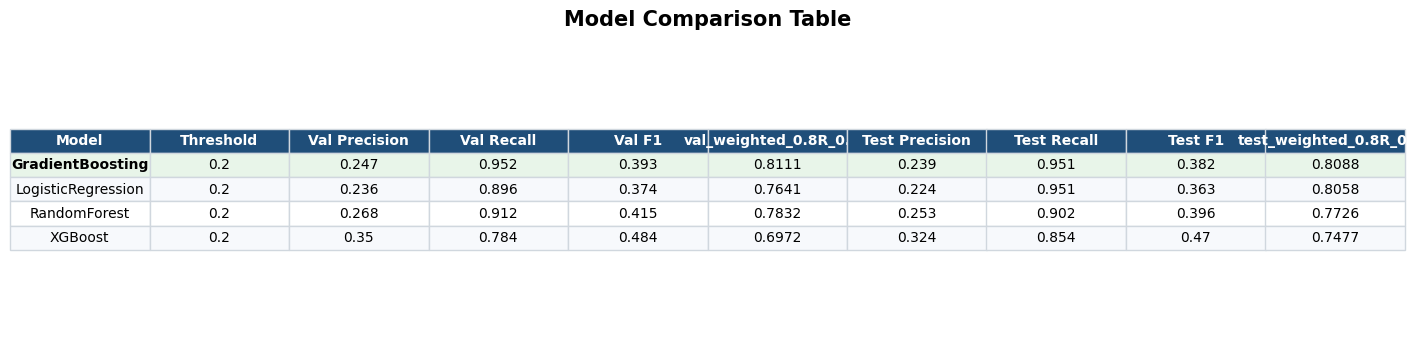

Saved image: c:\Users\acer\Desktop\programming\projects\Survival\comparison_table_github.png


In [ ]:
import matplotlib.pyplot as plt
from pathlib import Path

if 'comparison_df' not in globals():
    raise ValueError('comparison_df not found. Run the comparison table cell first.')

export_df = comparison_df.copy()

numeric_cols = [
    'threshold',
    'val_precision',
    'val_recall',
    'val_f1',
    'test_precision',
    'test_recall',
    'test_f1',
]
for col in numeric_cols:
    if col in export_df.columns:
        export_df[col] = export_df[col].round(3)

# Requested formatting: 0.8R+0.2P columns with 4 decimals
score_cols = ['val_0.8R+0.2P', 'test_0.8R+0.2P']
for col in score_cols:
    if col in export_df.columns:
        export_df[col] = export_df[col].round(4)

pretty_df = export_df.rename(
    columns={
        'model': 'Model',
        'threshold': 'Threshold',
        'val_precision': 'Val Precision',
        'val_recall': 'Val Recall',
        'val_f1': 'Val F1',
        'val_0.8R+0.2P': 'Val (0.8R+0.2P)',
        'test_precision': 'Test Precision',
        'test_recall': 'Test Recall',
        'test_f1': 'Test F1',
        'test_0.8R+0.2P': 'Test (0.8R+0.2P)',
    }
)

rows, cols = pretty_df.shape
fig_width = min(22, max(14, cols * 1.8))
fig_height = max(2.5, 1.4 + rows * 0.55)

fig, ax = plt.subplots(figsize=(fig_width, fig_height))
ax.axis('off')

table = ax.table(
    cellText=pretty_df.values,
    colLabels=pretty_df.columns,
    loc='center',
    cellLoc='center',
)

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.45)

header_color = '#1f4e79'
header_text_color = 'white'
main_row_color = '#e8f5e9'
alt_row_color = '#f7f9fc'

for (row, col), cell in table.get_celld().items():
    cell.set_edgecolor('#d0d7de')
    if row == 0:
        cell.set_facecolor(header_color)
        cell.get_text().set_color(header_text_color)
        cell.get_text().set_weight('bold')
    else:
        model_name = str(pretty_df.iloc[row - 1, 0])
        if model_name == 'GradientBoosting':
            cell.set_facecolor(main_row_color)
            if col == 0:
                cell.get_text().set_weight('bold')
        elif row % 2 == 0:
            cell.set_facecolor(alt_row_color)

plt.title('Model Comparison Table', fontsize=15, weight='bold', pad=18)

output_path = Path.cwd() / 'comparison_table_github.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()

print(f'Saved image: {output_path}')